In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import sqlite3
import mysql.connector as cnt
# import plotly.express as px

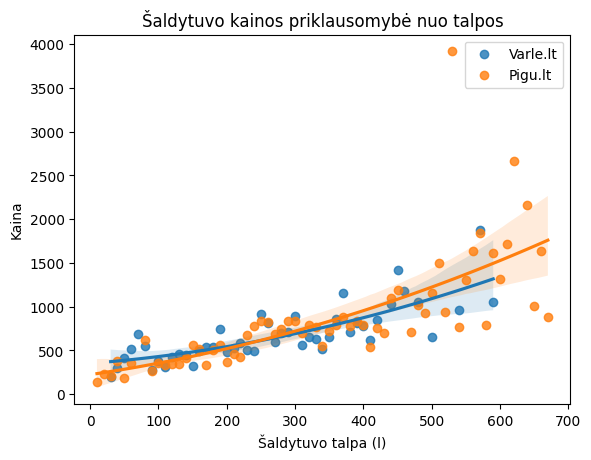

In [14]:
# Saldytuvai
SDB = sqlite3.connect('VarlePigu.db')
Cs = SDB.cursor()

sql1="""SELECT kaina, `talpa (l)`, `naudinga šaldytuvo talpa`, `šaldytuvo talpa [l]`,
`bendra talpa neto`, `šaldytuvo talpa neto`, `šaldytuvo talpa`, `bendros grynosios talpos`, `bendra talpa`, `šaldymo talpa`,
`šaldytuvo neto talpa`, `bendra neto talpa`, `bendroji talpa neto`, `šaldytuvo talpa (neto)`,
`talpa (neto)`, `šaldytuvo talpa (l)`, `grynoji talpa`, `bendroji talpa neto (l)`, `šaldytuvo talpa neto (l)`
FROM "SaldytuvaiVarle";
"""
df = pd.read_sql_query(sql1, con=SDB)

sql2="""SELECT kaina,
`Bendra talpa:`
FROM "SaldytuvaiPigu";
"""
dfp = pd.read_sql_query(sql2, con=SDB)

SDB.close()

for col in df.columns:
    if col != 'kaina':
        df['V'] = df['talpa (l)'].fillna(df[col])
    
df['kaina'] = df['kaina'].apply(lambda x: float(x))

df.dropna(subset='V', inplace=True)
dfv = df[['kaina', 'V']]
dfv['V'] = df['V'].apply(lambda x: float(x))
dfv['Vgr'] = dfv['V'].apply(lambda x: int(np.ceil(x/10) * 10))

dfv_gr = dfv[dfv['V'] < 700].groupby('Vgr').mean(numeric_only=True).round().reset_index()
dfv_gr.head()

# pigu
def set_talpa(x):
    if x is not None:
        return float(x.replace('l', ''))
    
dfp['talpa'] = dfp['Bendra talpa:'].apply(set_talpa)
dfp.dropna(subset='talpa', inplace=True)
dfp['talpa2'] = dfp['talpa'].apply(lambda x: int(np.ceil(x/10) * 10))
dfpv = dfp[['kaina', 'talpa2']]

dfpv_gr = dfpv.groupby('talpa2').mean(numeric_only=True).round().reset_index()
dfpv_gr.head()

fig, axis = plt.subplots()
sns.regplot(data=dfv_gr[dfv_gr['Vgr'] > 10], x='Vgr', y='kaina', order=2, ax=axis, label='Varle.lt')
sns.regplot(data=dfpv_gr, x='talpa2', y='kaina', order=2, ax=axis, label='Pigu.lt')
plt.title('Šaldytuvo kainos priklausomybė nuo talpos')
plt.ylabel('Kaina')
plt.xlabel('Šaldytuvo talpa (l)')
plt.legend()
plt.show()

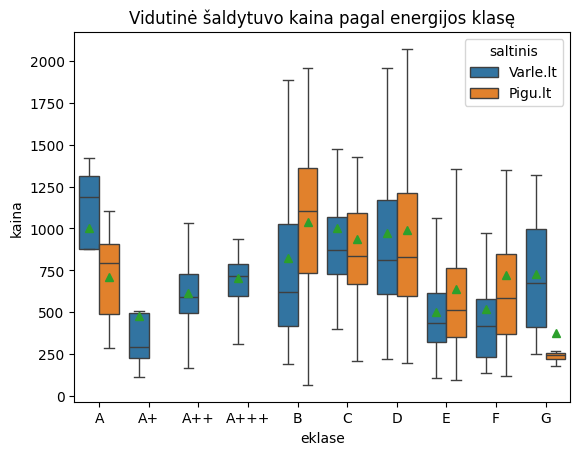

In [35]:
# energijos klase

SDB = sqlite3.connect('VarlePigu.db')
Cs = SDB.cursor()

sql="""SELECT kaina, 
`energijos klasė`, 
`energijos vartojimo efektyvumo klasė (reglamentas (es) 2017/1369)`,
`energijos efektyvumo klasė`
FROM "SaldytuvaiVarle";
"""
df = pd.read_sql_query(sql, con=SDB)

sql2="""SELECT kaina,
`Energijos klasė:`
FROM "SaldytuvaiPigu";
"""
dfp = pd.read_sql_query(sql2, con=SDB)
SDB.close()


for col in df.columns:
    if col != 'kaina':
        df['energijos klasė'] = df['energijos klasė'].fillna(df[col])
 

    
df['energijos klasė'] = df['energijos klasė'].apply(lambda x: x.upper() if x is not None else x)
df['eklase'] = df['energijos klasė']
df['kaina'] = df['kaina'].apply(lambda x: float(x))
df.dropna(subset='eklase', inplace=True)

# klases_v = sorted(list(set(df['energijos klasė'].tolist())))
dfe = df[['kaina', 'eklase']]
dfe['saltinis'] = 'Varle.lt'


# pigu
dfp['eklase'] = dfp['Energijos klasė:']
dfp.dropna(subset='eklase', inplace=True)
# klases = sorted(list(set(dfp['Energijos klasė:'].tolist())))
dfpe = dfp[['kaina', 'eklase']]
dfpe['saltinis'] = 'Pigu.lt'

# sujungiam dataframus
df_combined = pd.concat([dfe, dfpe])
klases = sorted(list(set(df_combined['eklase'].tolist())))

fig, ax = plt.subplots()
sns.boxplot(data=df_combined, x='eklase', y='kaina',hue='saltinis', showmeans=True, showfliers=False, order=klases)

plt.title('Vidutinė šaldytuvo kaina pagal energijos klasę')
plt.show()

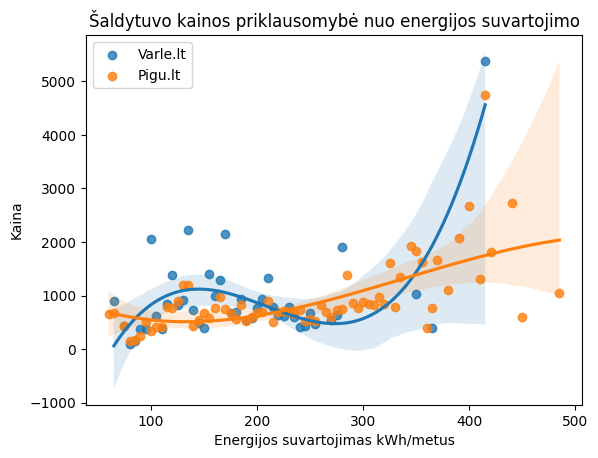

In [54]:
# Energijos sanaudos

SDB = sqlite3.connect('VarlePigu.db')
Cs = SDB.cursor()

sql="""SELECT kaina, 
`vidutinės metinės energijos sąnaudos kilovatvalandėmis per metus (kwh/m.)`,
`metinės energijos sąnaudos`,
`metinis energijos suvartojimas (kwh)`,
`energijos suvartojimas per metus`,
`energijos sąnaudos`,
`metinis energijos suvartojimas`,
`suvartojama energija`,
`bendras suvartojamos energijos kiekis per metus`,
`energijos sąnaudos (kwh/metus)`,
`suvartojama energija (kwh)`,
`bendras suvartojamos energijos kiekis per metus (kwh)`,
`energijos sąnaudos per metus`
FROM "SaldytuvaiVarle";
"""
df = pd.read_sql_query(sql, con=SDB)

sql2="""SELECT kaina,
`Energijos sąnaudos per metus:`
FROM "SaldytuvaiPigu";
"""
dfp = pd.read_sql_query(sql2, con=SDB)

SDB.close()

for col in df.columns:
    if col != 'kaina':
        df['energija'] = df['metinės energijos sąnaudos'].fillna(df[col])

df['kaina'] = df['kaina'].apply(lambda x: float(x))
dfe = df[['kaina', 'energija']]
dfe.dropna(subset='energija', inplace=True)
dfe['energija'] = dfe['energija'].apply(lambda x: x.replace('kWh/metus', '').replace('kWh', '').replace(',', '.'))
dfe['energija'] = dfe['energija'].apply(lambda x: float(x))
dfe['E'] = dfe['energija'].apply(lambda x: int(np.ceil(x/5) * 5))
dfe_gr = dfe.groupby('E').mean(numeric_only=True).round().reset_index()

# Pigu
dfp['sanaudos'] = dfp['Energijos sąnaudos per metus:'].str.extract('(\d+)')
dfp.dropna(subset='sanaudos', inplace=True)
dfp['sanaudos'] = dfp['sanaudos'].apply(lambda x: int(x))
dfpe = dfp[['kaina', 'sanaudos']]

dfpe['E'] = dfpe['sanaudos'].apply(lambda x: int(np.ceil(x/5) * 5))

dfpe_gr = dfpe.groupby('E').mean(numeric_only=True).round().reset_index()
dfpe_filtered = dfpe_gr[(dfpe_gr['E'] > 0) & (dfpe_gr['E'] < 500)]

fig, axis = plt.subplots()
sns.regplot(data=dfe_gr[dfe_gr['E'] < 500], x='E', y='kaina', order=3, ax=axis, label='Varle.lt')
sns.regplot(data=dfpe_filtered, x='E', y='kaina', order=3, ax=axis, label='Pigu.lt')
plt.title('Šaldytuvo kainos priklausomybė nuo energijos suvartojimo')
plt.ylabel('Kaina')
plt.xlabel('Energijos suvartojimas kWh/metus')
plt.legend()
plt.show()

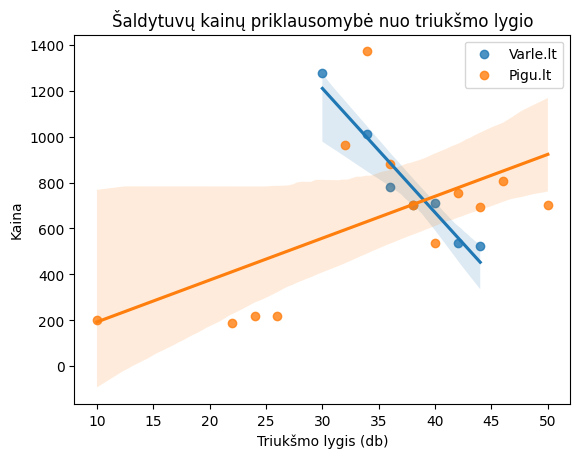

In [47]:
# garsas/triuksmas
SDB = sqlite3.connect('VarlePigu.db')
Cs = SDB.cursor()

sql="""SELECT kaina, 
`ore skleidžiamas akustinis triukšmas`,
`triukšmo lygis [db]`,
`maksimalus triukšmo lygis`,
`triukšmo lygis (db)`,
`triukšmo lygis`,
`triukšmo galia`,
`triukšmo lygis, db`,
`triukšmingumo lygis`,
`triukšmo lygis (db (a) re 1 pw)`,
`garso lygis`
FROM "SaldytuvaiVarle";
"""
df = pd.read_sql_query(sql, con=SDB)

sql2="""SELECT kaina,
`Maksimalus triukšmo lygis:`
FROM "SaldytuvaiPigu";
"""
dfp = pd.read_sql_query(sql2, con=SDB)
SDB.close()

df['kaina'] = df['kaina'].apply(lambda x: float(x))
for col in df.columns:
    if col != 'kaina':
        df['garsas'] = df['ore skleidžiamas akustinis triukšmas'].fillna(df[col])

df.dropna(subset='garsas', inplace=True)
df['garsas'] = df['garsas'].apply(lambda x: int(x[:2]))

dfg = df[['kaina', 'garsas']]
dfg['g2'] = dfg['garsas'].apply(lambda x: int(np.ceil(x/2) * 2))

dfg_gr = dfg.groupby('g2').mean(numeric_only=True).round().reset_index()
# dfg_gr['saltinis'] = 'Varle.lt'
# dfg_gr_1 = dfg_gr[['kaina', 'g2', 'saltinis']]


# Pigu
dfp['garsas'] = dfp['Maksimalus triukšmo lygis:'].str.extract('(\d+)')
dfp.dropna(subset='garsas', inplace=True)
dfp['garsas'] = dfp['garsas'].apply(lambda x: int(x))

dfpg = dfp[['kaina', 'garsas']]
dfpg['g2'] = dfpg['garsas'].apply(lambda x: int(np.ceil(x/2) * 2))

dfpg_gr = dfpg.groupby('g2').mean(numeric_only=True).round().reset_index()
# dfpg_gr['saltinis'] = 'Pigu.lt'

fig, axis = plt.subplots()
sns.regplot(data=dfg_gr, x='g2', y='kaina', order=1, ax=axis, label='Varle.lt')
sns.regplot(data=dfpg_gr, x='g2', y='kaina', order=1, ax=axis, label='Pigu.lt')
axis.set_xlabel('Triukšmo lygis (db)')
axis.set_ylabel('Kaina')
plt.title('Šaldytuvų kainų priklausomybė nuo triukšmo lygio')
plt.legend()
plt.show()